# Real or Fake? Detecting Fake news.

Fake news is rife. It is misinformation with the aim to misinform and to spread false imformation to either harm or influence with little to no evidence. In this notebook, we will explore datasets from genuine news articles and from fake news articles through graphs and examples such as word frequencies, bi-grams/tri-grams and word clouds. Then apply a classify to these datasets to see how well a machine can distinguish the difference between the two classes. Finally, we will evaluate these models using statistical evaluations such as precision, recall, F1 score and ROC.

Afterwards, the best model will be used to create a web application for users to input news articles and let the model predict whether to article is real or fake.

Dataset for this project from Kaggle. Click [Here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/notebooks)

In [1]:
# Import our visual libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Import text clearning libraries
import re
from bs4 import BeautifulSoup
import nltk

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/fake-and-real-news-dataset/True.csv


## Import the data

In [2]:
# Input full file path for True news dataset
real = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
# Input full file path for Fake news dataset
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Let's check the number of entries there are for each dataset.

In [4]:
print("Real news count: " + str(len(real)))
print("Fake news count: " + str(len(fake)))
print("Total available entries: " + str(len(real) + len(fake)))

Real news count: 21417
Fake news count: 23481
Total available entries: 44898


In [5]:
# Merge the datasets
real["label"] = 1
fake["label"] = 0

frame = [real, fake]
df = pd.concat(frame)

df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
df.tail()

,title,text,subject,date,label
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [7]:
# Check to see if any columns have missing values
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [8]:
# Get basic information on dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [9]:
# Run this cell to avoid indexes of previous datasets from overlapping
df.reset_index(inplace = True)
df.drop("index", axis=1, inplace = True)

In [10]:
df.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

Check an example of a fake news text:

In [11]:
df["text"][40000]

'A shocking new video has just been released by the Center for Medical Progress, the undercover investigative group that in 2015 released videos showing that Planned Parenthood affiliates have profited from selling the body parts of aborted babies.This latest video is a preview of footage that CMP investigators gathered at the 2014 and 2015 National Abortion Federation conventions, attended by hundreds of members of the abortion industry each year. (The NAF is a major trade group of North American abortion providers, and Planned Parenthood makes up about 50 percent of its members and leadership.)Notice the audience laughing at some of the most vile comments you have ever heard about the killing and dismembering of babies in the womb:https://youtu.be/Sq1ycCmX3uUHere are some of the most horrifying remarks from the brand-new undercover footage. Attendees made some of these comments during official presentations, and others directly to undercover CMP investigators.Dr. Lisa Harris, the med

You can probably tell from reading this article that the writing style is a sensationalist piece designed to prey of the fears of the reader. Examples being the mention of graphic imagery and not written by a professional.

Example of geniune news text:

In [12]:
df["text"][10000]

'PHOENIX (Reuters) - An Arizona man filed a lawsuit on Friday challenging the results of the state’s March presidential primary election, alleging misconduct by officials during a nominating contest that is already mired in controversy. The lawsuit filed by Tucson resident John Brakey alleges that officials improperly handled voter registration requests and permitted illegal votes to be cast in the election, which was marred by long lines at polling stations and allegations of discrimination against minority voters. The three-count complaint, filed late on Friday afternoon against Arizona’s secretary of state and 15 counties, also claims that erroneous ballots were counted by officials on election day. It seeks to enjoin the state from certifying the results “until such election is properly conducted and in compliance with every requirement of Arizona law,” according to the lawsuit. The legal action comes amid an investigation by the U.S. Department of Justice into the election’s handl

Here we can see the piece is well written by a professional writer, and the subject is on politics. What I have mentioned may be naive assumptions from just reading only two brief text. In the next section, we will be diving deep into the data to help better understand what differentiates genuine and fake news.

## Exploratory Data Analysis

**Label Count**

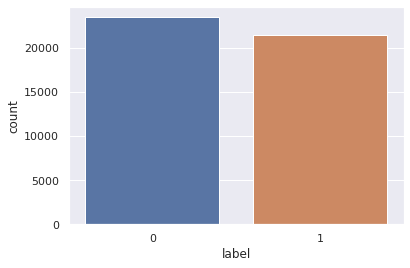

In [13]:
# 0 for fake
# 1 for true
sns.set(style="darkgrid")
sns.countplot(df["label"])

In [14]:
df["subject"].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

**Subject count by Label**

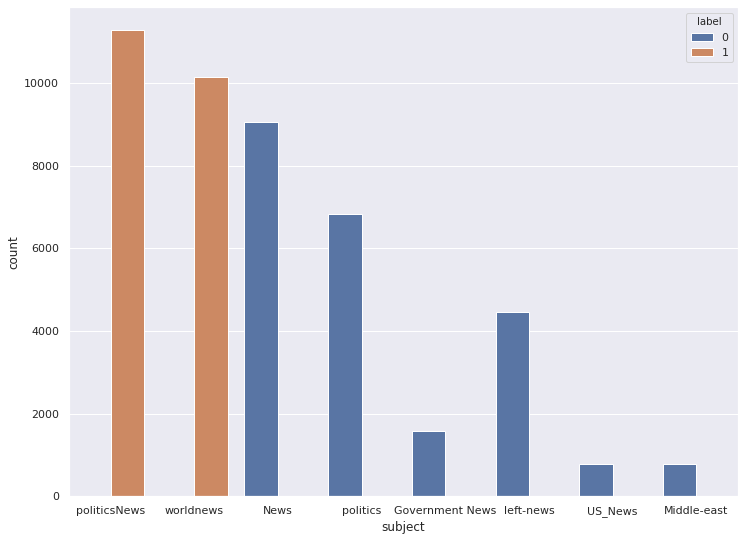

In [15]:
# Chart to show count of subject by label
plt.figure(figsize=(12,9))
sns.set(style="darkgrid")
sns.countplot(df["subject"], hue=df["label"])

Looking at the chart above, genuine news have the subjecst **politicsNews** and **worldnews**. Fake news will have the subjects **News, politics, Government News, left-news, US_News** and **Middle-east**.

**Publish data analysis**

In [16]:
set(df["date"])

{'January 12, 2016',
 'Nov 17, 2016',
 'Aug 11, 2015',
 'Sep 14, 2017',
 'March 1, 2017 ',
 'Dec 28, 2016',
 'November 4, 2017',
 'October 30, 2017 ',
 'May 8, 2016',
 'Jan 12, 2016',
 'March 23, 2016 ',
 'Jun 27, 2015',
 'Jun 15, 2016',
 'December 9, 2016 ',
 'Dec 18, 2017',
 'Aug 6, 2016',
 'Jun 25, 2015',
 'Oct 21, 2017',
 'February 4, 2017 ',
 'August 2, 2016',
 'November 13, 2016',
 'July 15, 2017',
 'Aug 30, 2017',
 'March 15, 2016 ',
 'Jan 18, 2017',
 'October 10, 2017',
 'August 12, 2017',
 'Apr 6, 2016',
 'December 28, 2016 ',
 'February 16, 2016',
 'Aug 7, 2015',
 'Apr 14, 2017',
 'Jun 1, 2015',
 'Jul 10, 2017',
 'November 26, 2017 ',
 'Aug 11, 2017',
 'June 24, 2016 ',
 'Oct 25, 2015',
 'Aug 14, 2017',
 'Jul 30, 2016',
 'Mar 21, 2017',
 'Oct 11, 2015',
 'Dec 23, 2016',
 'Mar 25, 2016',
 'April 23, 2016',
 'December 10, 2016 ',
 'December 21, 2017',
 'Mar 26, 2016',
 'September 24, 2016 ',
 'Oct 2, 2015',
 'March 27, 2017 ',
 'June 25, 2017',
 'Dec 28, 2015',
 'Oct 31, 2016',

Date contains http links and news article titles. Months may be shortened or only month.

In [17]:
# Filter out dates with http links
httpremove = "http"
filter1 = df["date"].str.contains(httpremove)
df_ = df[filter1]
df_

,title,text,subject,date,label
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,0
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0


In [18]:
df_["text"][30775]

'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'

In [19]:
# Dataset with wrong dates and meanliness text
df_ = df[df["date"].apply(lambda x: len(x) > 20)]
df_

,title,text,subject,date,label
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,0
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,0
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
40350,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,0
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0


It's okay to remove entries that are not considered news: all the text in this dataset contains http links and left-behind code.

In [20]:
# Want to remove entries which are not dates
df = df[df["date"].apply(lambda x: len(x) < 20)]
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [21]:
# 44888 entries after removing non-dates
df["title"].count()

44888

In [22]:
df_ = df.copy()

In [23]:
df_["date"]

0        December 31, 2017 
1        December 29, 2017 
2        December 31, 2017 
3        December 30, 2017 
4        December 29, 2017 
                ...        
44893      January 16, 2016
44894      January 16, 2016
44895      January 15, 2016
44896      January 14, 2016
44897      January 12, 2016
Name: date, Length: 44888, dtype: object

In [24]:
# Transform dates to datetime
# Use to_period('M') to get datetime to month
df_['date'] = pd.to_datetime(df_['date']).dt.to_period('M')
df_.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12,1


In [25]:
# Check count of articles by Year
# Over half of the articles are from 2017
df_["date"].apply(lambda x: (str(x)[:4])).value_counts()

2017    25904
2016    16470
2015     2479
2018       35
Name: date, dtype: int64

In [26]:
# Get number of articles by Year-Month
# Change date type to string from datetime format
df_["date"] = df_["date"].apply(lambda x: (str(x)[:7]))
df_.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12,1


In [27]:
# DataFrame of year of count by Year-Month
year_month = pd.DataFrame(df_["date"].value_counts()).sort_index()
year_month.reset_index(inplace=True)
year_month["index"] = year_month["index"].astype(str)
year_month

,index,date
0,2015-03,8
1,2015-04,326
2,2015-05,338
3,2015-06,236
4,2015-07,291
5,2015-08,220
6,2015-09,202
7,2015-10,281
8,2015-11,276
9,2015-12,301


<function matplotlib.pyplot.show(*args, **kw)>

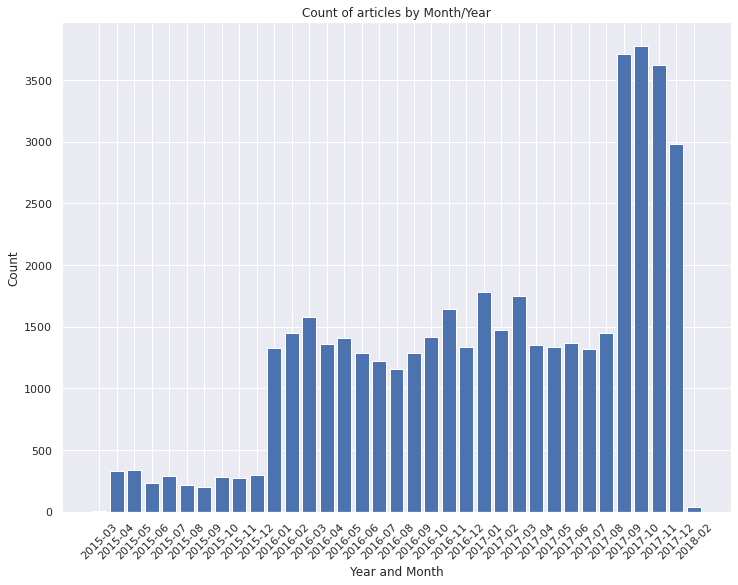

In [28]:
# Count of articles by Month
plt.figure(figsize=(12,9))
plt.bar(year_month["index"], year_month["date"])
plt.xticks(rotation=45)
plt.xlabel("Year and Month")
plt.ylabel("Count")
plt.title("Count of articles by Month/Year")
plt.show

**Count by Month-Year**

In [29]:
# Plot count of articles by Month-Year
df_1 = df_[df_["label"]==1]
df_0 = df_[df_["label"]==0]
df_1 = pd.DataFrame(df_1["date"].value_counts()).sort_index()
df_1.rename(columns={"date": "true"}, inplace=True)
df_0 = pd.DataFrame(df_0["date"].value_counts()).sort_index()
df_0.rename(columns={"date": "false"}, inplace=True)

new_df = df_1.join(df_0, how='outer')
new_df.reset_index(inplace=True)
new_df

,index,true,false
0,2015-03,NaN,8
1,2015-04,NaN,326
2,2015-05,NaN,338
3,2015-06,NaN,236
4,2015-07,NaN,291
5,2015-08,NaN,220
6,2015-09,NaN,202
7,2015-10,NaN,281
8,2015-11,NaN,276
9,2015-12,NaN,301


<function matplotlib.pyplot.show(*args, **kw)>

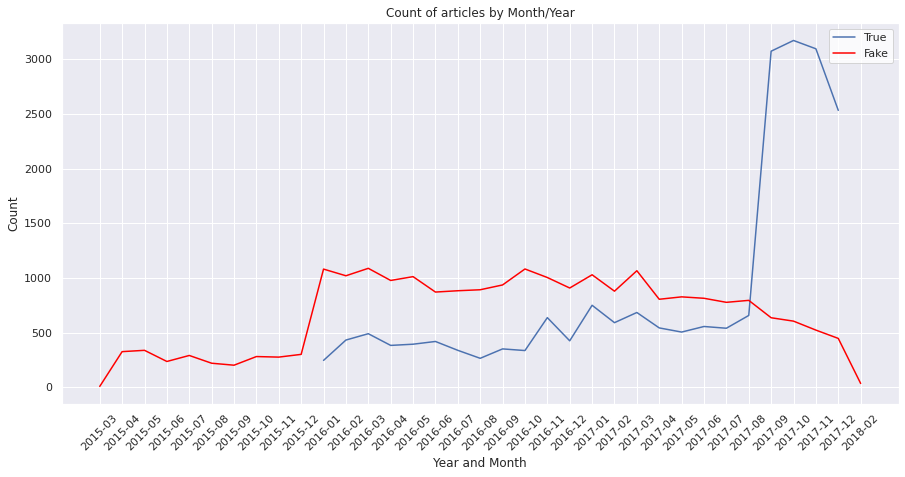

In [30]:
# Plot Count of articles by Month
plt.figure(figsize=(15,7))
plt.plot(new_df["index"], new_df["true"], label="True")
plt.plot(new_df["index"], new_df["false"], color="red", label="Fake")
plt.xticks(rotation=45)
plt.legend(facecolor='white')
plt.xlabel("Year and Month")
plt.ylabel("Count")
plt.title("Count of articles by Month/Year")
plt.show

Looking at the distribution of news articles by Month-Year, we can see that fake news was published between 2015-03 to 2018-02, and true news published from 2016-01 to 2017-12. The majority of the real news articles were from August to November of 2017 with at least 2500-3000 each month, making up over half of the total real news dataset.

The bulk of fake news articles were collected between January 2016 to August 2017, with around 700-1000 each month.

**Length of text (by characters)**

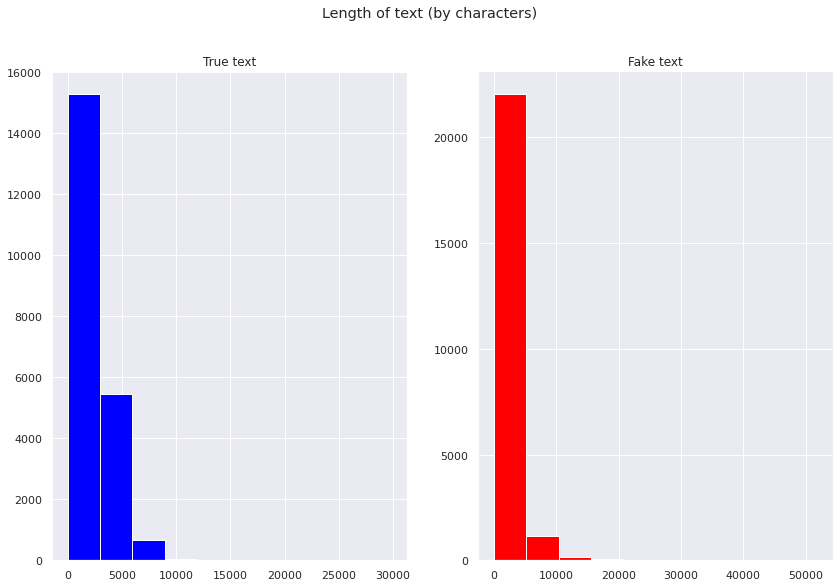

In [31]:
# Create side-by-side histograms of True and Fake news text
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,9))

true_length = df[df["label"]==1]["text"].str.len()
ax1.set_title("True text")
ax1.hist(true_length, color="blue")

fake_length = df[df["label"]==0]["text"].str.len()
ax2.set_title("Fake text")
ax2.hist(fake_length, color="red")

fig.suptitle("Length of text (by characters)")
plt.show()

Both true and fake news text have different distributions: true news text will have mostly around 2500 characters, fake news text will have mostly 5000 characters in their pieces.

In [32]:
df["title"].count()

44888

**Length of title (by characters)**

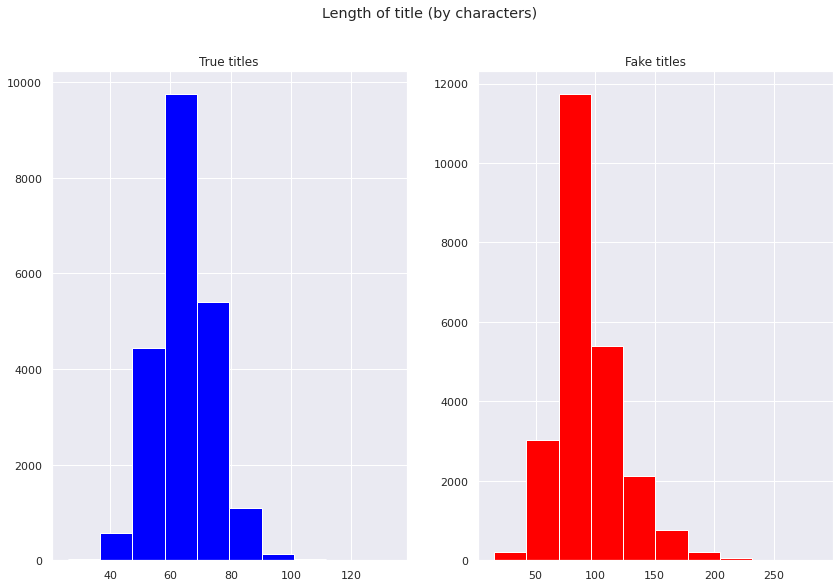

In [33]:
# Create side-by-side histograms of True and Fake news text
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,9))

true_length = df[df["label"]==1]["title"].str.len()
ax1.set_title("True titles")
ax1.hist(true_length, color="blue")

fake_length = df[df["label"]==0]["title"].str.len()
ax2.set_title("Fake titles")
ax2.hist(fake_length, color="red")

fig.suptitle("Length of title (by characters)")
plt.show()

Again the distributions for true and fake news are different. Going by the news titles, true news have mostly 60-80 characters in their titles, while fake news tend to be longer with 75-125 characters.

## Data preparation

We need to perform data cleaning in order to use the wordcloud to the best possible usage. This involves reducing down words to lower case, removing stopwords such as "a" or "as", and removing hyperlinks to other sites. Let's merge the text and title columns together. Remove the other columns becasue we will only be concentrating on the text itself and not the subject matter or date released.

In [34]:
# Merge text and title columns, remove title, subject and date.
df['text'] = df['title'] + " " + df['text']
del df['title']
del df['subject']
del df['date']

In [35]:
# Check if anything missing after cleaning
df.isna().sum()

text     0
label    0
dtype: int64

In [36]:
df.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [37]:
# Stopwords to remove from text will have little effect on the context of the text
# Stopwords in list already in lower case
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [38]:
# Use this to deal with apostophes and abbreviation
# df_["news"] = df_['news'].str.replace('[^\w\s]','')
def remove_apostrophe_abbrev(text):
    return re.sub('[^\w\s]','', text)

# Function to remove stopwords
def remove_stop_words(text):
    clean_text = []
    for word in text.split():
        if word.strip().lower() not in stop_words:
            clean_text.append(word)
            
    return " ".join(clean_text)


In [39]:
# Text example of stop words removed
remove_stop_words(df["text"][0])

'U.S. budget fight looms, Republicans flip fiscal script WASHINGTON (Reuters) - head conservative Republican faction U.S. Congress, voted month huge expansion national debt pay tax cuts, called “fiscal conservative” Sunday urged budget restraint 2018. keeping sharp pivot way among Republicans, U.S. Representative Mark Meadows, speaking CBS’ “Face Nation,” drew hard line federal spending, lawmakers bracing battle January. return holidays Wednesday, lawmakers begin trying pass federal budget fight likely linked issues, immigration policy, even November congressional election campaigns approach Republicans seek keep control Congress. President Donald Trump Republicans want big budget increase military spending, Democrats also want proportional increases non-defense “discretionary” spending programs support education, scientific research, infrastructure, public health environmental protection. “The (Trump) administration already willing say: ‘We’re going increase non-defense discretionary 

In [40]:
# Functions for cleaning text

# Remove html tags, using regex is bad idea
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove links in text, http and https
# s? in regex means or s (case sensitive)
def remove_links(text):
    return re.sub('https?:\/\/\S+', '', text)

# Remove 's (possessive pronouns) from text
# Two kinds of apostophes found
def remove_possessive_pronoun(text):
    return re.sub("’s|'s", '', text)

# Remove between brackets and their contents
def remove_between_brackets(text):
    return re.sub('\([^]]*\)', '', text)

# Remove square brackets and their contents
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Remove curly brackets and their contents
# Useful to remove any JavaScript scripts, though removed
# through html as above
def remove_between_curly_brackets(text):
    return re.sub('\{[^]]*\}', '', text)

def remove_n_space(text):
    return re.sub('\n', '', text)

def text_cleaner(text):
    text = remove_html_tags(text)
    text = remove_links(text)
    text = remove_possessive_pronoun(text)
    text = remove_apostrophe_abbrev(text)
    text = remove_between_brackets(text)
    text = remove_between_square_brackets(text)
    text = remove_between_curly_brackets(text)
    text = remove_n_space(text)
    text = remove_stop_words(text)
    
    return text

In [41]:
# Apply cleaning functions to text
df["text"] = df["text"].apply(text_cleaner)

### Word Cloud

In [42]:
from wordcloud import WordCloud, STOPWORDS 

**Word Cloud for true news**

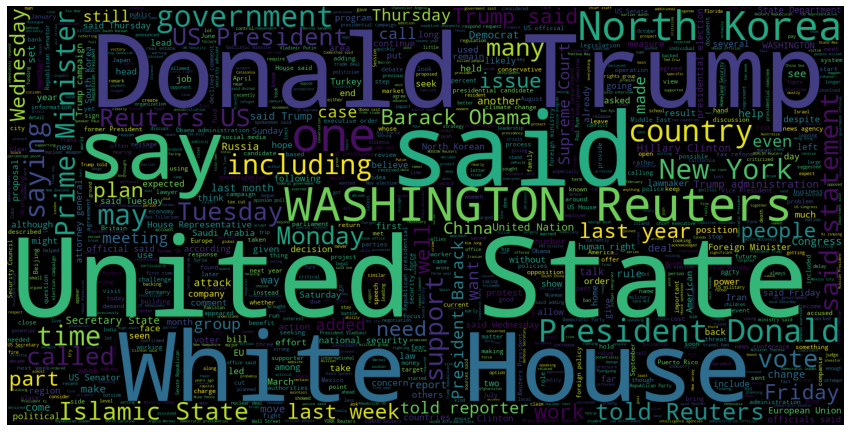

In [43]:
# True news wordcloud
plt.figure(figsize=(15,15))
wordcloud = WordCloud(max_words = 1000 , width = 1600 , 
                      height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df["label"] == 1].text))

plt.axis("off")
plt.imshow(wordcloud)

**Word Cloud for fake news**

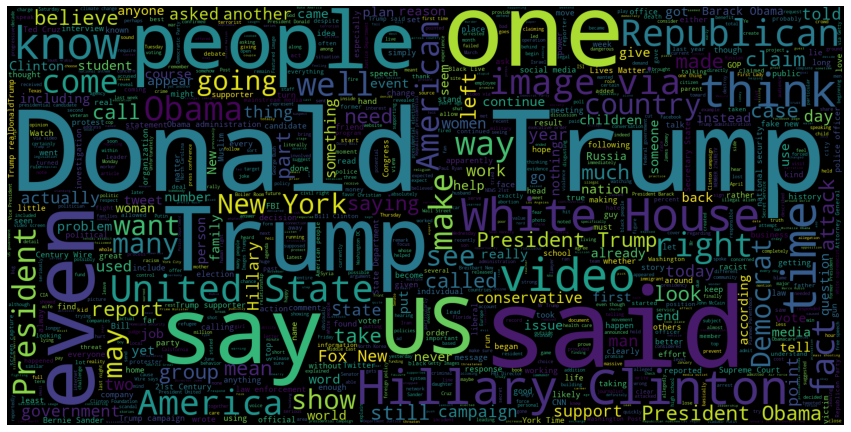

In [44]:
# Fake news wordcloud
plt.figure(figsize=(15,15))
wordcloud = WordCloud(max_words = 1000 , width = 1600 , 
                      height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df["label"] == 0].text))

plt.axis("off")
plt.imshow(wordcloud)

You can tell from both word clouds there is no distint words which can determine whether the text is more likely to be true or fake. Both seem include words associates with U.S. politics and U.S. Politicians.

Okay, let's explore frequency of words in text.

**Frequent words**

In [45]:
from collections import Counter

In [46]:
# Get 25 most common words in True news
true_corpus = pd.Series(" ".join(df[df["label"] == 1].text))[0].split()

counter = Counter(true_corpus)
true_common = counter.most_common(25)
true_common = dict(true_common)
true_common

{'said': 99037,
 'Trump': 59692,
 'US': 42758,
 'would': 31707,
 'Reuters': 28414,
 'government': 18030,
 'President': 17515,
 'House': 16812,
 'Republican': 15967,
 'also': 15762,
 'United': 15089,
 'people': 14457,
 'told': 14282,
 'could': 13905,
 'States': 12408,
 'state': 12352,
 'last': 11710,
 'election': 11655,
 'year': 11017,
 'one': 11007,
 'campaign': 10707,
 'two': 10623,
 'Donald': 10506,
 'North': 10154,
 'Clinton': 10109}

In [47]:
# as a dataframe
true_common_df = pd.DataFrame(true_common.items(), columns = ["words", "count"])
true_common_df.set_index("words")

,count
words,
said,99037
Trump,59692
US,42758
would,31707
Reuters,28414
government,18030
President,17515
House,16812
Republican,15967


<function matplotlib.pyplot.show(*args, **kw)>

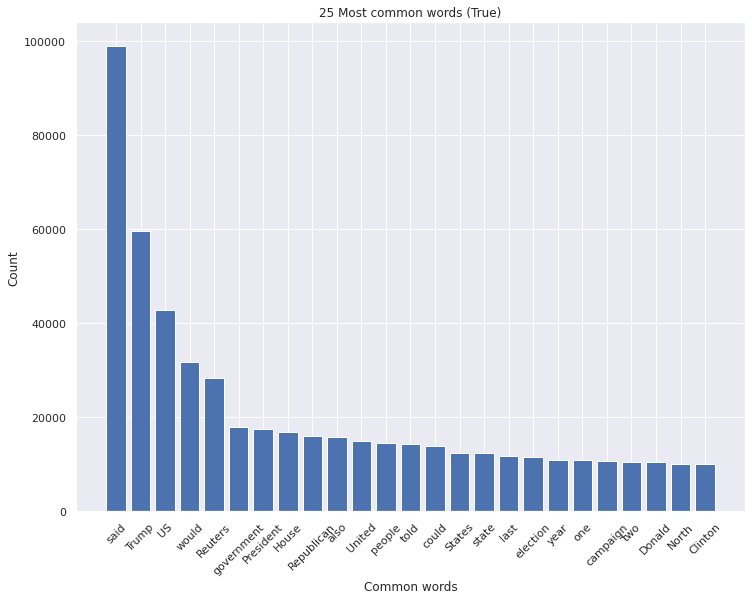

In [48]:
# Histogram of 25 true common words
plt.figure(figsize=(12,9))
plt.bar(true_common.keys(), true_common.values())
plt.xticks(rotation=45)
plt.xlabel("Common words")
plt.ylabel("Count")
plt.title("25 Most common words (True)")
plt.show

In [49]:
# Get 25 most common words in Fake news
fake_corpus = pd.Series(" ".join(df[df["label"] == 0].text))[0].split()

counter = Counter(fake_corpus)
fake_common = counter.most_common(25)
fake_common = dict(fake_common)
fake_common

{'Trump': 80439,
 'said': 30904,
 'people': 24813,
 'would': 23214,
 'one': 20179,
 'Obama': 19256,
 'Clinton': 18657,
 'Donald': 17798,
 'President': 17151,
 'like': 17050,
 'US': 15751,
 'Hillary': 14945,
 'also': 14756,
 'even': 12519,
 'time': 12090,
 'America': 10949,
 'media': 10370,
 'get': 10326,
 'campaign': 10290,
 'know': 10221,
 'American': 10150,
 'House': 9955,
 'could': 9941,
 'going': 9713,
 'Republican': 9269}

In [50]:
# as a dataframe
fake_common_df = pd.DataFrame(fake_common.items(), columns = ["words", "count"])
fake_common_df.set_index("words")

,count
words,
Trump,80439
said,30904
people,24813
would,23214
one,20179
Obama,19256
Clinton,18657
Donald,17798
President,17151


<function matplotlib.pyplot.show(*args, **kw)>

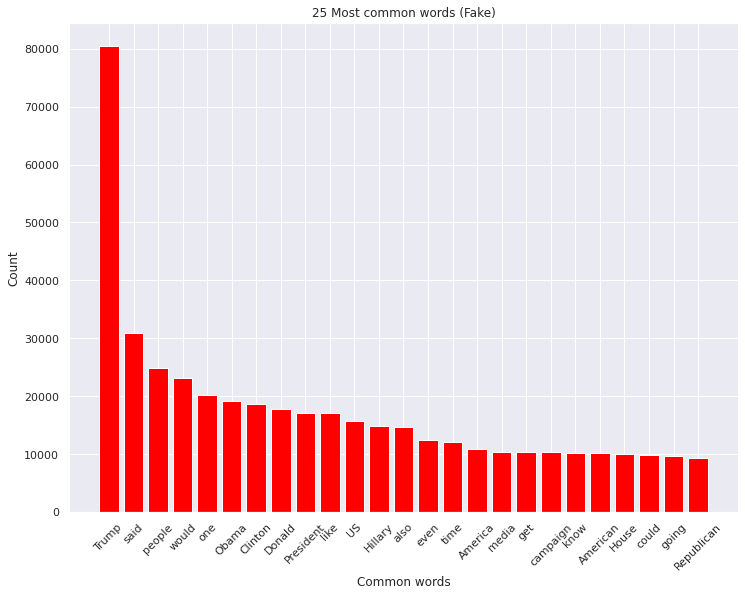

In [51]:
# Histogram of 25 fake common words
plt.figure(figsize=(12,9))
plt.bar(fake_common.keys(), fake_common.values(), color="red")
plt.xticks(rotation=45)
plt.xlabel("Common words")
plt.ylabel("Count")
plt.title("25 Most common words (Fake)")
plt.show

So from these list of common words, the distribution of news leans towards U.S. politics and that there is no telling what is true news and what is fake news. This makes fake news all the more dangerous and harmful if taken at face value.

### Bigrams and Trigrams

Let's look further into the text with bigrams and trigrams, and find common pair words and three-words.

**Bigrams**

In [52]:
from nltk.util import ngrams

Bigram: True news

In [53]:
# Find most common bigrams in True news
text = pd.Series(" ".join(df[df["label"] == 1].text))[0]
tokenizer = nltk.RegexpTokenizer(r"\w+")
token = tokenizer.tokenize(text)

# ngrams set to 2
counter = Counter(ngrams(token,2))
most_common = counter.most_common(25)
most_common = dict(most_common)
most_common

{('United', 'States'): 12211,
 ('Donald', 'Trump'): 10178,
 ('White', 'House'): 9164,
 ('WASHINGTON', 'Reuters'): 6483,
 ('North', 'Korea'): 6352,
 ('President', 'Donald'): 5915,
 ('said', 'statement'): 3926,
 ('New', 'York'): 3804,
 ('Reuters', 'US'): 3651,
 ('Islamic', 'State'): 3606,
 ('told', 'Reuters'): 3491,
 ('Trump', 'said'): 3463,
 ('Barack', 'Obama'): 3343,
 ('told', 'reporters'): 3176,
 ('last', 'year'): 3158,
 ('said', 'would'): 2998,
 ('US', 'President'): 2963,
 ('last', 'week'): 2923,
 ('Prime', 'Minister'): 2918,
 ('President', 'Barack'): 2867,
 ('Supreme', 'Court'): 2668,
 ('Trump', 'administration'): 2568,
 ('Hillary', 'Clinton'): 2535,
 ('said', 'Trump'): 2376,
 ('House', 'Representatives'): 2255}

In [54]:
# as a dataframe
true_common_bi = pd.DataFrame(most_common.items(), columns = ["bigram", "count"])
true_common_bi["bigram"] = true_common_bi["bigram"].apply(lambda x: " ".join(x))
true_common_bi

,bigram,count
0,United States,12211
1,Donald Trump,10178
2,White House,9164
3,WASHINGTON Reuters,6483
4,North Korea,6352
5,President Donald,5915
6,said statement,3926
7,New York,3804
8,Reuters US,3651
9,Islamic State,3606


<function matplotlib.pyplot.show(*args, **kw)>

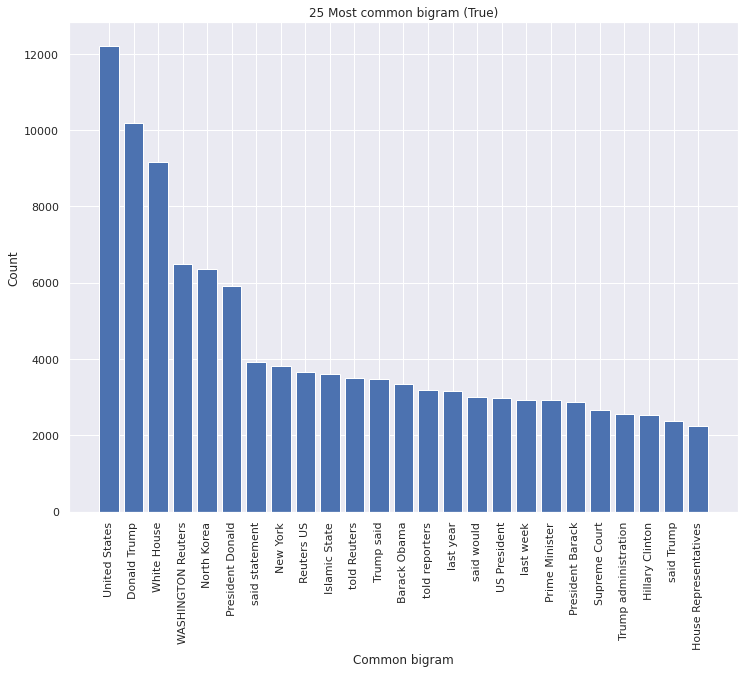

In [55]:
# Histogram of 25 common bigrams for True news
plt.figure(figsize=(12,9))
plt.bar(true_common_bi["bigram"], true_common_bi["count"]) # can do tuples
plt.xticks(rotation=90)
plt.xlabel("Common bigram")
plt.ylabel("Count")
plt.title("25 Most common bigram (True)")
plt.show

Bigram: Fake news

In [56]:
# Find most common bigrams in Fake news
text = pd.Series(" ".join(df[df["label"] == 0].text))[0]
tokenizer = nltk.RegexpTokenizer(r"\w+")
token = tokenizer.tokenize(text)

# ngrams set to 2
counter = Counter(ngrams(token,2))
most_common = counter.most_common(25)
most_common = dict(most_common)
most_common

{('Donald', 'Trump'): 13707,
 ('Hillary', 'Clinton'): 6977,
 ('White', 'House'): 6533,
 ('United', 'States'): 6187,
 ('image', 'via'): 6066,
 ('New', 'York'): 4240,
 ('President', 'Obama'): 3934,
 ('President', 'Trump'): 3785,
 ('Fox', 'News'): 2745,
 ('Barack', 'Obama'): 2254,
 ('Donald', 'J'): 2162,
 ('21st', 'Century'): 2150,
 ('J', 'Trump'): 2127,
 ('Century', 'Wire'): 1924,
 ('Supreme', 'Court'): 1873,
 ('Trump', 'realDonaldTrump'): 1672,
 ('Trump', 'campaign'): 1655,
 ('social', 'media'): 1569,
 ('Ted', 'Cruz'): 1558,
 ('Bernie', 'Sanders'): 1549,
 ('York', 'Times'): 1511,
 ('State', 'Department'): 1501,
 ('Washington', 'Post'): 1495,
 ('law', 'enforcement'): 1494,
 ('Obama', 'administration'): 1406}

In [57]:
# as a dataframe
fake_common_bi = pd.DataFrame(most_common.items(), columns = ["bigram", "count"])
fake_common_bi["bigram"] = fake_common_bi["bigram"].apply(lambda x: " ".join(x))
fake_common_bi

,bigram,count
0,Donald Trump,13707
1,Hillary Clinton,6977
2,White House,6533
3,United States,6187
4,image via,6066
5,New York,4240
6,President Obama,3934
7,President Trump,3785
8,Fox News,2745
9,Barack Obama,2254


<function matplotlib.pyplot.show(*args, **kw)>

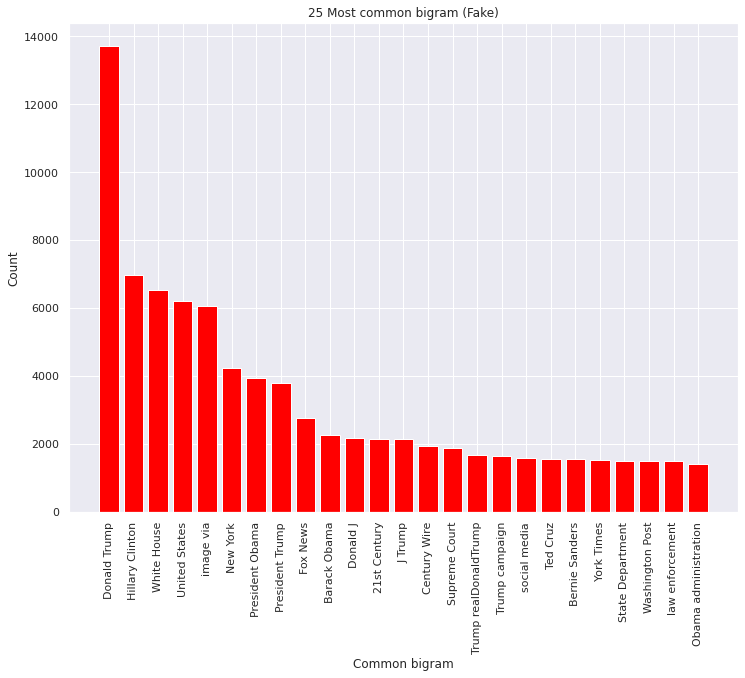

In [58]:
# Histogram of 25 common bigrams for Fakefake news
plt.figure(figsize=(12,9))
plt.bar(fake_common_bi["bigram"], fake_common_bi["count"], color="red") # can do tuples
plt.xticks(rotation=90)
plt.xlabel("Common bigram")
plt.ylabel("Count")
plt.title("25 Most common bigram (Fake)")
plt.show

From these fake news bigrams, it's interesting to see news sources Fox News, realDonaldTrump and 21st Century appear. For real news, Reuters more frequent as a news source.

Trigrams

Trigrams: True news

In [59]:
# Find most common trigrams in True news
text = pd.Series(" ".join(df[df["label"] == 1].text))[0]
tokenizer = nltk.RegexpTokenizer(r"\w+")
token = tokenizer.tokenize(text)

# ngrams set to 3
counter = Counter(ngrams(token,3))
most_common = counter.most_common(25)
most_common = dict(most_common)
most_common

{('President', 'Donald', 'Trump'): 5844,
 ('President', 'Barack', 'Obama'): 2867,
 ('US', 'President', 'Donald'): 2524,
 ('WASHINGTON', 'Reuters', 'US'): 2351,
 ('Reuters', 'US', 'President'): 1010,
 ('White', 'House', 'said'): 959,
 ('Presidentelect', 'Donald', 'Trump'): 814,
 ('President', 'Vladimir', 'Putin'): 782,
 ('US', 'House', 'Representatives'): 780,
 ('Nov', '8', 'election'): 747,
 ('NEW', 'YORK', 'Reuters'): 733,
 ('Reuters', 'President', 'Donald'): 688,
 ('WASHINGTON', 'Reuters', 'President'): 684,
 ('George', 'W', 'Bush'): 670,
 ('Secretary', 'State', 'Rex'): 652,
 ('State', 'Rex', 'Tillerson'): 651,
 ('Russian', 'President', 'Vladimir'): 610,
 ('Speaker', 'Paul', 'Ryan'): 604,
 ('Prime', 'Minister', 'Theresa'): 584,
 ('Minister', 'Theresa', 'May'): 584,
 ('Chancellor', 'Angela', 'Merkel'): 568,
 ('national', 'security', 'adviser'): 565,
 ('UN', 'Security', 'Council'): 563,
 ('Donald', 'Trump', 'said'): 562,
 ('New', 'York', 'Times'): 539}

In [60]:
# as a dataframe
true_common_tri = pd.DataFrame(most_common.items(), columns = ["trigram", "count"])
true_common_tri["trigram"] = true_common_tri["trigram"].apply(lambda x: " ".join(x))
true_common_tri

,trigram,count
0,President Donald Trump,5844
1,President Barack Obama,2867
2,US President Donald,2524
3,WASHINGTON Reuters US,2351
4,Reuters US President,1010
5,White House said,959
6,Presidentelect Donald Trump,814
7,President Vladimir Putin,782
8,US House Representatives,780
9,Nov 8 election,747


<function matplotlib.pyplot.show(*args, **kw)>

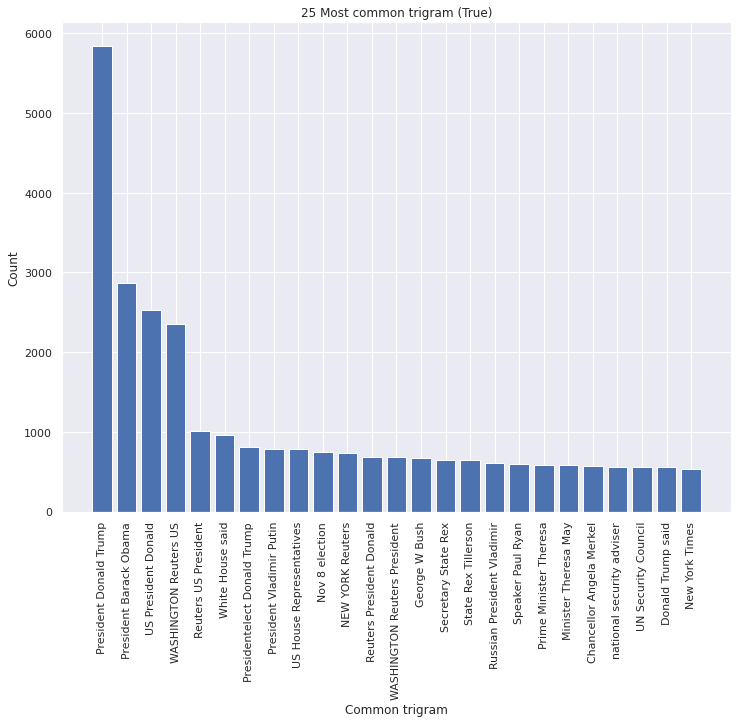

In [61]:
# Histogram of 25 common trigrams for True news
plt.figure(figsize=(12,9))
plt.bar(true_common_tri["trigram"], true_common_tri["count"])
plt.xticks(rotation=90)
plt.xlabel("Common trigram")
plt.ylabel("Count")
plt.title("25 Most common trigram (True)")
plt.show

Trigram: Fake News

In [62]:
# Find most common trigrams in Fake news
text = pd.Series(" ".join(df[df["label"] == 0].text))[0]
tokenizer = nltk.RegexpTokenizer(r"\w+")
token = tokenizer.tokenize(text)

# ngrams set to 3
counter = Counter(ngrams(token,3))
most_common = counter.most_common(25)
most_common = dict(most_common)
most_common

{('Donald', 'J', 'Trump'): 2121,
 ('21st', 'Century', 'Wire'): 1900,
 ('J', 'Trump', 'realDonaldTrump'): 1670,
 ('New', 'York', 'Times'): 1501,
 ('Black', 'Lives', 'Matter'): 1221,
 ('NEWS', '21st', 'Century'): 925,
 ('President', 'Barack', 'Obama'): 819,
 ('image', 'via', 'video'): 781,
 ('President', 'Donald', 'Trump'): 777,
 ('Century', 'Wire', 'says'): 725,
 ('video', 'screen', 'capture'): 717,
 ('via', 'video', 'screen'): 666,
 ('New', 'York', 'City'): 606,
 ('Featured', 'image', 'via'): 599,
 ('George', 'W', 'Bush'): 584,
 ('President', 'United', 'States'): 568,
 ('via', 'Getty', 'Images'): 534,
 ('SUBSCRIBE', 'BECOME', 'MEMBER'): 477,
 ('via', 'screen', 'capture'): 473,
 ('21WIRE', 'SUBSCRIBE', 'BECOME'): 471,
 ('BECOME', 'MEMBER', '21WIRETV'): 455,
 ('belowFeatured', 'image', 'via'): 443,
 ('Director', 'James', 'Comey'): 420,
 ('FBI', 'Director', 'James'): 408,
 ('image', 'via', 'screen'): 399}

In [63]:
# as a dataframe
fake_common_tri = pd.DataFrame(most_common.items(), columns = ["trigram", "count"])
fake_common_tri["trigram"] = fake_common_tri["trigram"].apply(lambda x: " ".join(x))
fake_common_tri

,trigram,count
0,Donald J Trump,2121
1,21st Century Wire,1900
2,J Trump realDonaldTrump,1670
3,New York Times,1501
4,Black Lives Matter,1221
5,NEWS 21st Century,925
6,President Barack Obama,819
7,image via video,781
8,President Donald Trump,777
9,Century Wire says,725


<function matplotlib.pyplot.show(*args, **kw)>

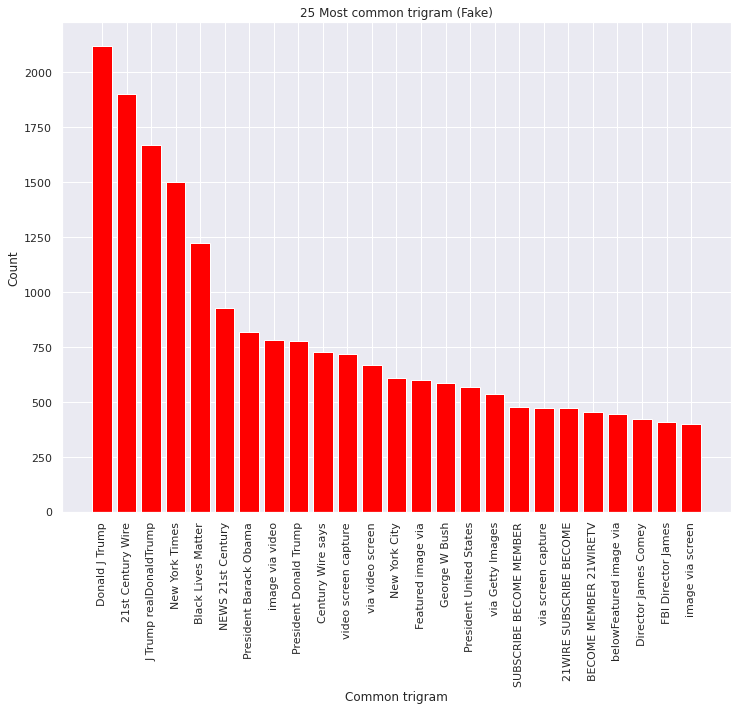

In [64]:
# Histogram of 25 common trigrams for True news
plt.figure(figsize=(12,9))
plt.bar(fake_common_tri["trigram"], fake_common_tri["count"], color="red")
plt.xticks(rotation=90)
plt.xlabel("Common trigram")
plt.ylabel("Count")
plt.title("25 Most common trigram (Fake)")
plt.show

## Lemmatization

In [65]:
from nltk.stem import WordNetLemmatizer


lemma = WordNetLemmatizer()

In [66]:
# Lemmatizer example
print(lemma.lemmatize("boys"))

boy


In [67]:
# Function to perform lemmatization on text
def lemmatize_text(text):
    tokenize_text = nltk.word_tokenize(text)
    lemmatize_words = [lemma.lemmatize(word) for word in tokenize_text]
    join_text = ' '.join(lemmatize_words)
    
    return join_text

# Example sentence on function
lemmatize_text("There once was a boy named Naruto who was possessed by a Nine-Tailed Demon Fox")

'There once wa a boy named Naruto who wa possessed by a Nine-Tailed Demon Fox'

In [68]:
# Copy main df dataset and lemmatize the text
lemmatized_df = df.copy()
lemmatized_df["text"] = lemmatized_df["text"].apply(lemmatize_text)
lemmatized_df.head()

,text,label
0,US budget fight loom Republicans flip fiscal s...,1
1,US military accept transgender recruit Monday ...,1
2,Senior US Republican senator Let Mr Mueller jo...,1
3,FBI Russia probe helped Australian diplomat ti...,1
4,Trump want Postal Service charge much Amazon s...,1


In [69]:
lemmatized_df["text"][0]

'US budget fight loom Republicans flip fiscal script WASHINGTON Reuters head conservative Republican faction US Congress voted month huge expansion national debt pay tax cut called fiscal conservative Sunday urged budget restraint 2018 keeping sharp pivot way among Republicans US Representative Mark Meadows speaking CBS Face Nation drew hard line federal spending lawmaker bracing battle January return holiday Wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even November congressional election campaign approach Republicans seek keep control Congress President Donald Trump Republicans want big budget increase military spending Democrats also want proportional increase nondefense discretionary spending program support education scientific research infrastructure public health environmental protection Trump administration already willing say going increase nondefense discretionary spending 7 percent Meadows chairman small influential House Fr

After must needed data cleaning and extensive exploratory analysis, let's move on to training the dataset on machine learning models to see how well it could predict whether the text is real or fake.

## Machine Learning

### Training models

We will begin training models and experiment with different vector methods, CountVectorizer and TF-IDF, with lemmatized text. We will use the following models:
* Logistic Regression
* Naive Bayes
* Support Vector Machine
* Random Forest
* Gradient Boosting

In [70]:
# Machine Learning models to import
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [71]:
# Random state at 42 for reproducibility
# Go for 80:20 train:test set
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(lemmatized_df["text"], lemmatized_df["label"], test_size=test_size, random_state=42)

**CountVectorizer**

In [72]:
# Fit CountVectorizer to X_train and X_test datasets
cv_train = CountVectorizer(max_features=10000).fit(X_train)
X_vec_train = cv_train.transform(X_train)
X_vec_test = cv_train.transform(X_test)

In [73]:
X_vec_train

<35910x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 5215137 stored elements in Compressed Sparse Row format>

**Logistic Regression (CountVectorizer)**

In [74]:
# Training on Logistic Regression model
# set LR parameter max_iter = 4000 to avoid error
lr = LogisticRegression(max_iter = 4000)
lr.fit(X_vec_train, y_train)
predicted_value = lr.predict(X_vec_test)
lr_accuracy_value = roc_auc_score(y_test, predicted_value)

In [75]:
# Logistic Regression Test ROC 99.68% on just lemmatized text
print("ROC: " + str(lr_accuracy_value*100) + "%")

ROC: 99.67501876760714%


In [76]:
conmat = confusion_matrix(y_test, predicted_value)
print(conmat)
print(classification_report(y_test, predicted_value))

[[4664   13]
 [  16 4285]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4677
           1       1.00      1.00      1.00      4301

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



Text(0.5, 12.5, 'predicted values')

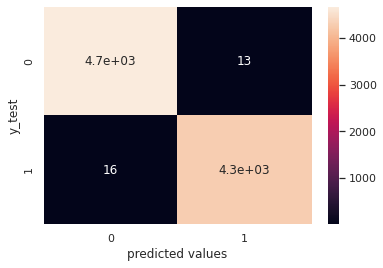

In [77]:
# Visual of confusion matrix of Logistic Regression
fig = plt.subplot()
sns.heatmap(conmat, annot=True, ax=fig)
fig.set_ylabel('y_test')
fig.set_xlabel('predicted values')

**Multinomial Naive Bayes (CountVectorizer)**

In [78]:
# Training on Naive Bayes model
# Quick at training
nb = MultinomialNB()
nb.fit(X_vec_train, y_train)
predicted_value = nb.predict(X_vec_test)
nb_accuracy_value = roc_auc_score(y_test, predicted_value)

In [79]:
# Naive Bayes Training ROC 95.21% lemmatized text
print("ROC: " + str(roc_auc_score(y_train, nb.predict(X_vec_train))*100) + "%")

ROC: 95.21233841890586%


In [80]:
# Naive Bayes Test ROC 95.22% lemmatized text
print("ROC: " + str(nb_accuracy_value*100) + "%")

ROC: 95.22161137499188%


In [81]:
conmat = confusion_matrix(y_test, predicted_value)
print(conmat)
print(classification_report(y_test, predicted_value))

[[4466  211]
 [ 217 4084]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4677
           1       0.95      0.95      0.95      4301

    accuracy                           0.95      8978
   macro avg       0.95      0.95      0.95      8978
weighted avg       0.95      0.95      0.95      8978



Text(0.5, 12.5, 'predicted values')

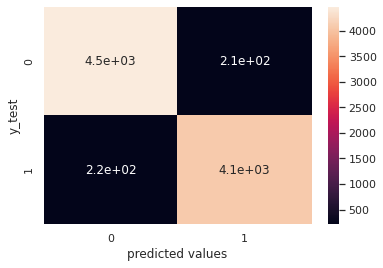

In [82]:
# Visual of confusion matrix of Naive Bayes
fig = plt.subplot()
sns.heatmap(conmat, annot=True, ax=fig)
fig.set_ylabel('y_test')
fig.set_xlabel('predicted values')

**Support Vector Machines (CountVectorizer)**

In [83]:
# Training on Support Vector Machine
# Very slow at training
# time complexity O(no.features * no.of samples**2)
svm = SVC()
svm.fit(X_vec_train, y_train)
predicted_value = svm.predict(X_vec_test)
svm_accuracy_value = roc_auc_score(y_test, predicted_value)

In [84]:
# SVM Training ROC 99.9% lemmatized text
# svm predict on training set took very long time
print("ROC: " + str(roc_auc_score(y_train, svm.predict(X_vec_train))*100) + "%")

ROC: 99.89838226601833%


In [85]:
# SVM Test ROC 99.53% lemmatized text
print("ROC: " + str(svm_accuracy_value*100) + "%")

ROC: 99.52576030247303%


In [86]:
conmat = confusion_matrix(y_test, predicted_value)
print(conmat)
print(classification_report(y_test, predicted_value))

[[4662   15]
 [  27 4274]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4677
           1       1.00      0.99      1.00      4301

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



Text(0.5, 12.5, 'predicted values')

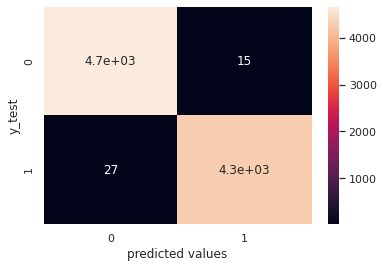

In [87]:
# Visual of confusion matrix of SVM
fig = plt.subplot()
sns.heatmap(conmat, annot=True, ax=fig)
fig.set_ylabel('y_test')
fig.set_xlabel('predicted values')

**Random Forest (CountVectorizer)**

In [88]:
# Training on Random Forest
rf = RandomForestClassifier()
rf.fit(X_vec_train, y_train)
predicted_value = rf.predict(X_vec_test)
rf_accuracy_value = roc_auc_score(y_test, predicted_value)

In [89]:
# Random Forest Training ROC 100% lemmatized text
print("ROC: " + str(roc_auc_score(y_train, rf.predict(X_vec_train))*100) + "%")

ROC: 100.0%


In [90]:
# Random Forest Test ROC 99.67% lemmatized text
print("ROC: " + str(rf_accuracy_value*100) + "%")

ROC: 99.66806651316526%


In [91]:
conmat = confusion_matrix(y_test, predicted_value)
print(conmat)
print(classification_report(y_test, predicted_value))

[[4659   18]
 [  12 4289]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4677
           1       1.00      1.00      1.00      4301

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



Text(0.5, 12.5, 'predicted values')

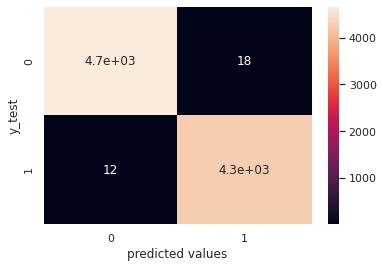

In [92]:
# Visual of confusion matrix of Random Forest
fig = plt.subplot()
sns.heatmap(conmat, annot=True, ax=fig)
fig.set_ylabel('y_test')
fig.set_xlabel('predicted values')

**Gradient Boosting (CountVectorizer)**

In [93]:
# Training on Gradient Boosting 
gbc = GradientBoostingClassifier()
gbc.fit(X_vec_train, y_train)
predicted_value = gbc.predict(X_vec_test)
gbc_accuracy_value = roc_auc_score(y_test, predicted_value)

In [94]:
# Gradient Boost Training ROC 99.64% lemmatized text
print("ROC: " + str(roc_auc_score(y_train, gbc.predict(X_vec_train))*100) + "%")

ROC: 99.64230359925274%


In [95]:
# Gradient Boost Test ROC 99.5% lemmatized text
print("ROC: " + str(gbc_accuracy_value*100) + "%")

ROC: 99.49514751530603%


In [96]:
conmat = confusion_matrix(y_test, predicted_value)
print(conmat)
print(classification_report(y_test, predicted_value))

[[4645   32]
 [  14 4287]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4677
           1       0.99      1.00      0.99      4301

    accuracy                           0.99      8978
   macro avg       0.99      0.99      0.99      8978
weighted avg       0.99      0.99      0.99      8978



Text(0.5, 12.5, 'predicted values')

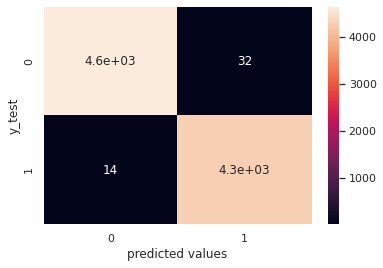

In [97]:
# Visual of confusion matrix of Gradient Boosting
fig = plt.subplot()
sns.heatmap(conmat, annot=True, ax=fig)
fig.set_ylabel('y_test')
fig.set_xlabel('predicted values')

So it looks like most of the models did fairly well. On comparing training accuracy and test acccuracy difference, it seems the **Gradient Boosting** did pretty well. When training accuracy is 100%, then there may be a problem of the model overfitting, and this could lead to new news data being predicted incorrectly.

Now lets save the Gradient Boosting file.

## Saving the model

In [99]:
import pickle

In [101]:
# Save model
model_file = "gbc.pkl"
with open(model_file,mode='wb') as model_f:
    pickle.dump(gbc,model_f)

In [108]:
# Open the model, print result for sanity check
with open("gbc.pkl",mode='rb') as model_f:
    model = pickle.load(model_f)
    predict = model.predict(X_vec_test)
    result = roc_auc_score(y_test, predict)
    print("result:",result*100, "%")

result: 99.49514751530603 %


**What have we learnt**
* How to clean dataset by removing tags, punctuation, stopwords
* How to use lemmatization to remove duplicated word meanings
* Play with data to produce visualizations like countplots and wordcloud
* Look for frequent words, sequence of words (bi-grams, tri-grams)
* Train machine learning models by using CountVectorizer on text dataset
* Evaluate model's training and test accuracy, classification report and confusion matrix
* Save model as pkl file for reuse.